In [1]:
!pip install transformers datasets evaluate accelerate umap umap-learn transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.4 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=aee592d9959b0f393ea66166dc9d20738d647436f5c04357a0fb98b37b4746ab
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=811

In [2]:
import torch
import pandas as pd
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score,f1_score
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer,AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments


In [3]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

def tokenize(batch):
  return tokenizer(batch["text"],padding=True,truncation=True)

def extract_hidden_state(batch):
  model_ckpt = "distilbert-base-uncased"
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = AutoModel.from_pretrained(model_ckpt).to(device)
  inputs = tokenizer(batch["text"],padding=True, truncation=True,return_tensors="pt")
  inputs = {a:b.to(device) for a,b in inputs.items()}
  with torch.no_grad():
    outputs = model(**inputs).last_hidden_state
  return {"last_hidden_state":outputs[:,0].cpu().numpy()}

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

def compute_metrics(pred):
  labels=pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds,average="weighted")
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

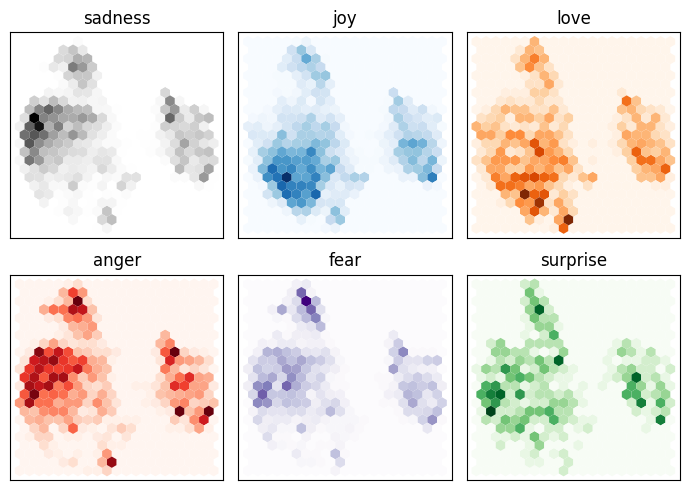

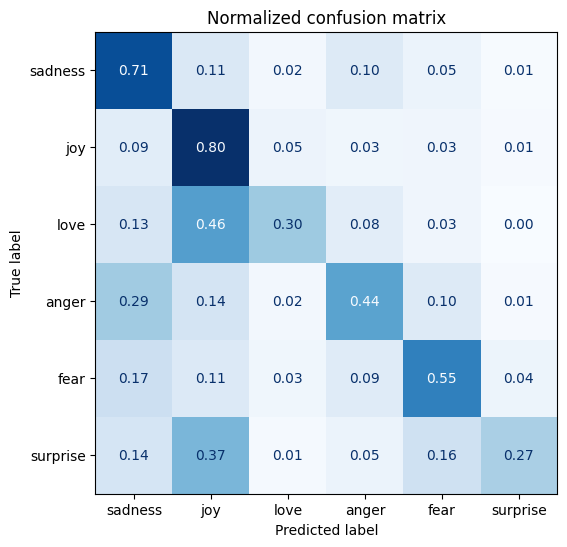

In [4]:
emotions = load_dataset("emotion")
train_ds = emotions["train"]
emotions.set_format("pandas")
df = emotions["train"][:]
df["label_name"] = df["label"].apply(label_int2str)

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

emotions.reset_format()
emotions_encoded = emotions.map(tokenize,batched=True,batch_size=None)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)
emotions_encoded = emotions_encoded.map(extract_hidden_state,batched=True)

x_train = np.array(emotions_encoded["train"]["last_hidden_state"])
x_valid = np.array(emotions_encoded["validation"]["last_hidden_state"])
y_train = np.array(emotions_encoded["train"]["label"])
y_valid = np.array(emotions_encoded["validation"]["label"])

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_train)
mapper = UMAP(n_components=2,metric="cosine").fit(x_scaled)
df_emb = pd.DataFrame(mapper.embedding_,columns = ["x","y"])
df_emb["label"] = y_train

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["x"], df_emb_sub["y"], cmap=cmap,
                 gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()


lr = LogisticRegression(max_iter=3000)
lr.fit(x_train,y_train)
lr.score(x_valid,y_valid)
y_preds = lr.predict(x_valid)
plot_confusion_matrix(y_preds, y_valid, labels)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.313570,0.908000,0.907292
2,No log,0.214025,0.927000,0.927029


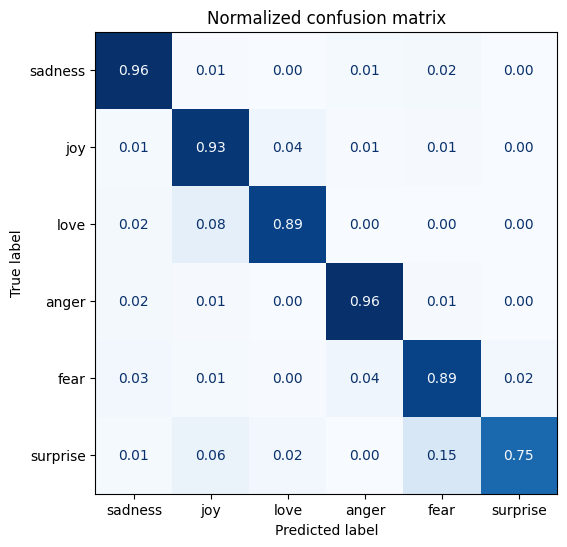

In [5]:
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels).to(device))

batch_size = 64
logging_steps = len(emotions_encoded["train"])
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                               num_train_epochs=2,
                               learning_rate=2e-5,
                               per_device_train_batch_size=batch_size,
                               per_device_eval_batch_size=batch_size,
                               weight_decay=0.01,
                               evaluation_strategy="epoch",
                               disable_tqdm=False,
                               logging_steps = logging_steps,
                               push_to_hub=False,
                               log_level="error")

trainer = Trainer(model=model,args = training_args,compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()
preds_output = trainer.predict(emotions_encoded["validation"])
y_preds = np.argmax(preds_output.predictions,axis=1)
plot_confusion_matrix(y_preds,y_valid,labels)